In [1]:
#download the data and save it to poem.txt
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O book.txt

--2023-12-21 08:29:06--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: ‘book.txt’

book.txt            100%[===================>] 593.27K  3.82MB/s    in 0.2s    

2023-12-21 08:29:07 (3.82 MB/s) - ‘book.txt’ saved [607504/607504]



In [2]:
#read the file in text string
text = open('book.txt', 'r', encoding='utf-8').read()
text = text.lower()

In [3]:
#create list of sentences
sentences = text.split('\n')

In [4]:
#import dependencies to preprocess the text data and making sequences
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
#initialize the tokenizer, which can work char by char
tokenizer = Tokenizer(oov_token='<UNK>')

In [6]:
tokenizer.fit_on_texts(sentences)

In [7]:
vocab_size = len(tokenizer.word_index) + 1 # 1 is added for unknown tokens
vocab_size

8923

In [8]:
sequences=tokenizer.texts_to_sequences(sentences)

In [9]:
input_sequences = []
for sequence in sequences:
  for i in range(1, len(sequence)):
    n_gram_sequence = sequence[:i+1]
    input_sequences.append(n_gram_sequence)

In [10]:
print(input_sequences[0], input_sequences[1], input_sequences[2], input_sequences[3])

[4776, 158] [4776, 158, 331] [4776, 158, 331, 886] [4776, 158, 331, 886, 5]


In [11]:
#find the maximum length among sequences
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

20

In [12]:
#pad the sequences to ensure that they are all of same length
padded_sequences = pad_sequences(input_sequences, maxlen = max_seq_len)

In [13]:
print(padded_sequences[0], padded_sequences[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 4776  158] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 4776  158  331]


In [14]:
import numpy as np
padded_sequences = np.array(padded_sequences)

In [15]:
print(len(padded_sequences[0]))
print(len(padded_sequences[1]))

20
20


In [16]:
#prepare training sequences and labels
#we will keep the last value of the sequence as our target label and all values before that as input to sequence model
x = padded_sequences[:, : -1]
labels = padded_sequences[:, -1]

In [17]:
x.shape

(101523, 19)

In [18]:
labels.shape

(101523,)

In [19]:
#to one hot encode the labels
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)
y.shape

(101523, 8923)

In [20]:
#import dependencies for defining the model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.optimizers import Adam

In [21]:
#define and compile the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(vocab_size, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 100)           892300    
                                                                 
 bidirectional (Bidirection  (None, 512)               731136    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8923)              4577499   
                                                                 
Total params: 6200935 (23.65 MB)
Trainable params: 6200935 (23.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
#initialize the callback for early stopping the training if there is not at least 1% improvement in the accuracy
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'acc', min_delta=0.01, patience=2)

In [23]:
model_history=model.fit(x, y, epochs=50, verbose=1, batch_size=512, callbacks=[es])

Epoch 1/50
199/199 [==============================] - 29s 118ms/step - loss: 6.2030 - acc: 0.0839
Epoch 2/50
199/199 [==============================] - 11s 57ms/step - loss: 5.3110 - acc: 0.1410
Epoch 3/50
199/199 [==============================] - 9s 47ms/step - loss: 4.7708 - acc: 0.1727
Epoch 4/50
199/199 [==============================] - 8s 42ms/step - loss: 4.2551 - acc: 0.2025
Epoch 5/50
199/199 [==============================] - 9s 47ms/step - loss: 3.7677 - acc: 0.2460
Epoch 6/50
199/199 [==============================] - 9s 45ms/step - loss: 3.3227 - acc: 0.2949
Epoch 7/50
199/199 [==============================] - 8s 42ms/step - loss: 2.9588 - acc: 0.3480
Epoch 8/50
199/199 [==============================] - 8s 40ms/step - loss: 2.6530 - acc: 0.3975
Epoch 9/50
199/199 [==============================] - 8s 41ms/step - loss: 2.3988 - acc: 0.4403
Epoch 10/50
199/199 [==============================] - 8s 39ms/step - loss: 2.1930 - acc: 0.4797
Epoch 11/50
199/199 [===============

In [24]:
# Time to become a storyteller!
seed_text = "I could not help laughing at the ease with which he explained his process of deduction"
next_words = 100

for _ in range(next_words):
    sequence = tokenizer.texts_to_sequences([seed_text])
    padded = pad_sequences(sequence, maxlen=max_seq_len - 1)
    predicted = model.predict(padded, verbose=0)
    predicted_index = np.argmax(predicted)
    output_word = ''

    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += ' ' + output_word

print(seed_text)


I could not help laughing at the ease with which he explained his process of deduction “when i had seen the matter in which he had shown him at great a mind whistle but it was in the way of the world ” i answered “the cases which are very old and from that my dear fellow wanted is a list from which you may observe that no one little ” said he ‘his cases whom it is a large square but the son buttons upon his feet and hurried round the corner to open and the door of the house and see all the shadow of the shadow came to my room there are the


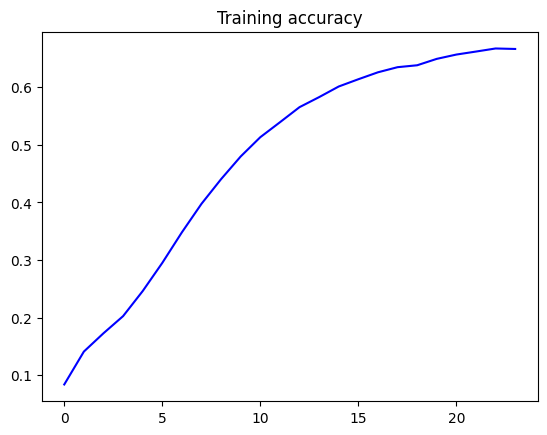

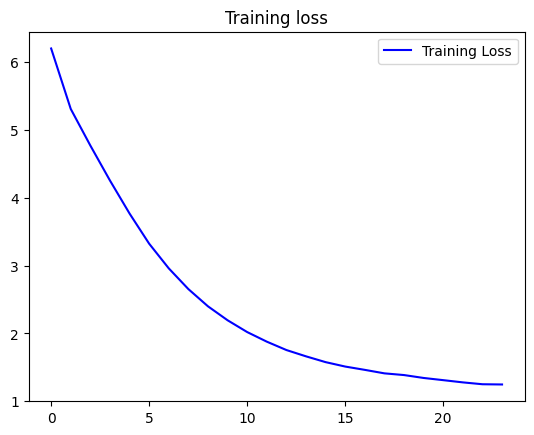

In [25]:
#let's look at how loss and accuracy changed while training
import matplotlib.pyplot as plt

acc = model_history.history['acc']
loss = model_history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()